In [123]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from datetime import datetime
from sklearn import tree
from sklearn import ensemble
from sklearn.cross_validation import train_test_split
import catboost
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier

In [2]:
os.chdir('E:\personal project\Lending Club')
df = pd.read_csv('LoanStats3d.csv',dtype='str',encoding='latin-1')
df=df.loc[df.loan_status!='Current',:]
df.shape

(255118, 145)

In [3]:
# Find and filter out the features that have more 50% of missing value 
delete_col=df.isnull().sum()[df.isnull().sum()/len(df)>0.5].index.tolist()
df.drop(delete_col,inplace=True,axis=1)
df.shape

(255118, 88)

In [4]:
# variables will not be used for applications model
not_used_cols=['grade', 'sub_grade','int_rate','funded_amnt','funded_amnt_inv','issue_d','pymnt_plan','out_prncp','out_prncp_inv','total_pymnt','total_pymnt_inv',
'total_rec_prncp','total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee','last_pymnt_d','last_pymnt_amnt',
'collections_12_mths_ex_med','policy_code','delinq_amnt','hardship_flag','debt_settlement_flag','last_credit_pull_d']

In [5]:
df.drop(not_used_cols,inplace=True,axis=1)
df.reset_index(drop=True,inplace=True)
df.shape

(255118, 64)

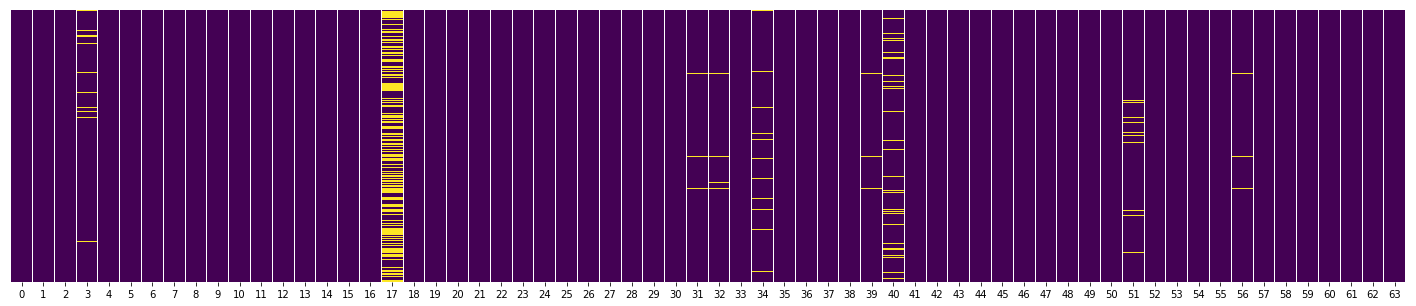

In [45]:
plt.figure(figsize=(25,5)) 
sns.set_context(font_scale=10)   
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis',xticklabels=list(range(len(df.columns))))

In [6]:
# remove units
df.revol_util=df.revol_util.str[:-1]
df.term=df.term.str[:3]

df.emp_length[(df.emp_length!='1 year')&(df.emp_length!='< 1 year')&(df.emp_length!='10+ years')]=df.emp_length[(df.emp_length!='1 year')&(df.emp_length!='< 1 year')&(df.emp_length!='10+ years')].str[:-6]
df.emp_length[df.emp_length=='< 1 year']=df.emp_length[df.emp_length=='< 1 year'].str[:-5]
df.emp_length[df.emp_length=='1 year']=df.emp_length[df.emp_length=='1 year'].str[:-5]
df.emp_length[df.emp_length=='10+ years']=df.emp_length[df.emp_length=='10+ years'].str[:-7]
# '<1 year'-->0, '10+ years'-->10
df.emp_length[df.emp_length=='< 1']=0
df.emp_length[df.emp_length=='']=np.nan

In [7]:
# good loans(0) and bad loan(1) 
df.loan_status.value_counts()

Fully Paid            183593
Charged Off            62042
Late (31-120 days)      5485
In Grace Period         2943
Late (16-30 days)       1033
Default                   22
Name: loan_status, dtype: int64

In [8]:
# good loans(0) and bad loan(1) 
df['label']='0'
df.loc[df.loan_status.isin(['Charged Off','Late (31-120 days)','Default']),'label']='1'

In [9]:
df.label.value_counts()

0    187569
1     67549
Name: label, dtype: int64

In [10]:
# transform date into duration (in years)
earl_d=df.earliest_cr_line
earl_y=[datetime.strptime(x,'%b-%y').year for x in earl_d]
dur_y=np.repeat(2015,len(earl_y))-earl_y

In [11]:
df['dur_y']=dur_y

In [12]:
df.isnull().sum()[df.isnull().sum()>0]

emp_title                  14093
emp_length                 14080
title                         67
dti                            2
mths_since_last_delinq    122809
revol_util                   113
bc_open_to_buy              2582
bc_util                     2763
mo_sin_old_il_acct          6936
mths_since_recent_bc        2469
mths_since_recent_inq      22908
num_rev_accts                  1
num_tl_120dpd_2m           11744
percent_bc_gt_75            2753
dtype: int64

In [13]:
df.fillna(-999,inplace=True)

In [14]:
# exclude 'zip_code', 'emp_title','disbursement_method','title','earliest_cr_line'
l_int=['loan_amnt','emp_length','delinq_2yrs','inq_last_6mths',
      'mths_since_last_delinq','open_acc','pub_rec','revol_bal','total_acc','acc_now_delinq','tot_coll_amt',
      'tot_cur_bal','total_rev_hi_lim','acc_open_past_24mths','avg_cur_bal', 'bc_open_to_buy','chargeoff_within_12_mths', 
       'mo_sin_old_il_acct','mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl','mort_acc', 
       'mths_since_recent_bc', 'mths_since_recent_inq','num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl','num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 
       'num_tl_120dpd_2m','num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m','pub_rec_bankruptcies','tax_liens', 
       'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit','total_il_high_credit_limit','dur_y']
l_float=['annual_inc','installment','dti','revol_util','bc_util','pct_tl_nvr_dlq', 'percent_bc_gt_75']
l_object=['term','home_ownership','verification_status', 'loan_status', 'purpose', 
          'addr_state', 'initial_list_status', 'application_type', 'label']

In [15]:
for i in l_int:
    df[i]=df[i].astype(int)
for i in l_float:
    df[i]=df[i].astype(float)
for i in l_object:
    df[i]=df[i].astype(object)

In [16]:
len(l_float)+len(l_int)+len(l_object)

61

In [17]:
dff=df.drop(['loan_status','zip_code', 'emp_title','disbursement_method','title','earliest_cr_line'],axis=1)

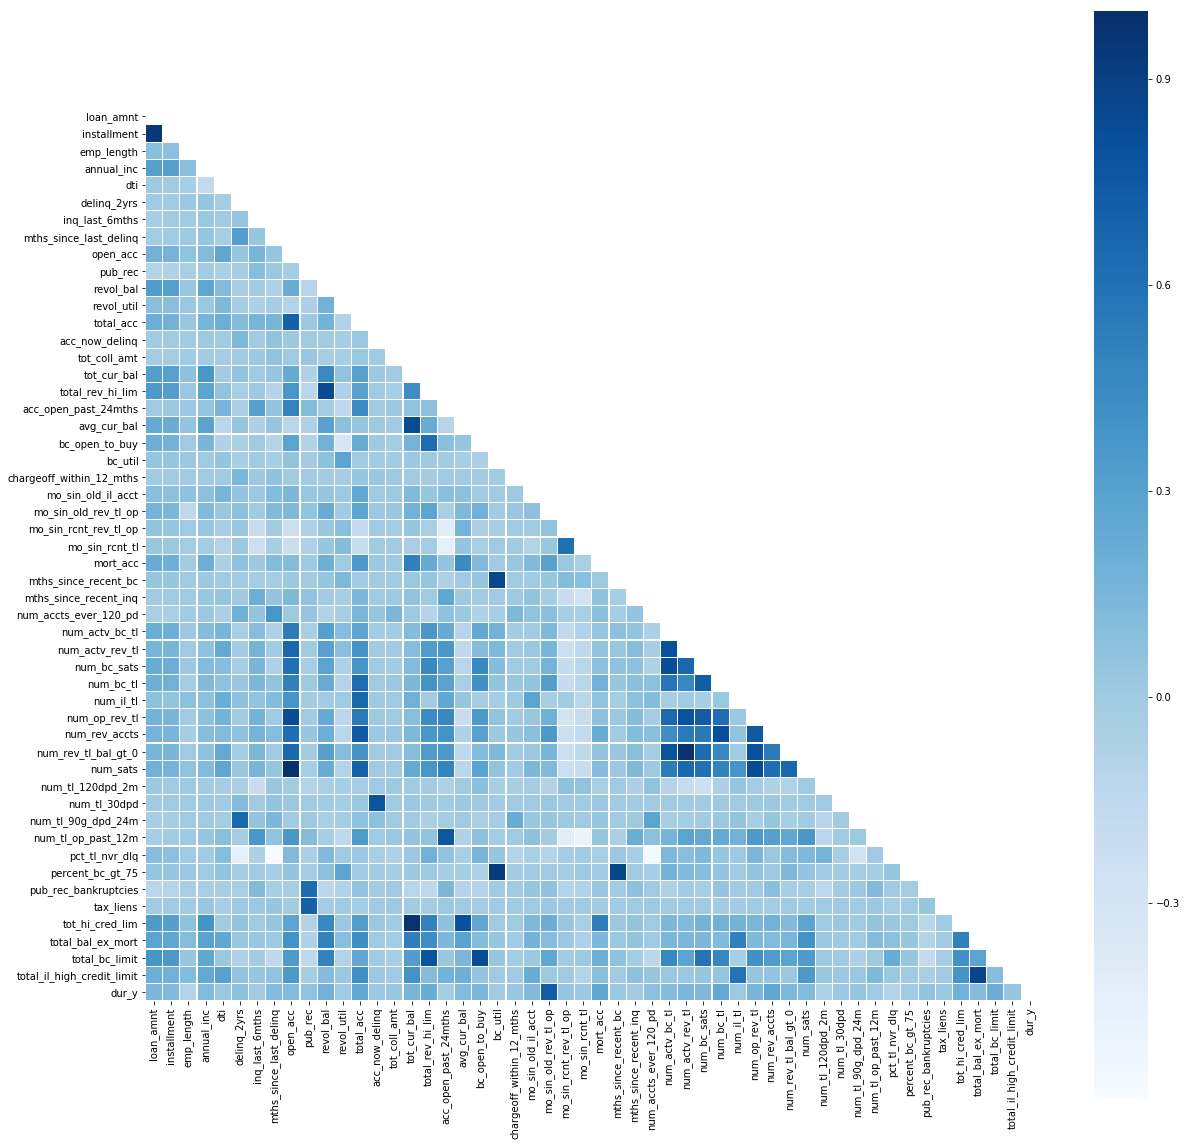

In [27]:
corr=dff.corr()
plt.figure(figsize=(20,20))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,cmap=plt.cm.Blues,mask=mask,square=True,annot_kws={'size':8},linewidths=0.1)

In [24]:
#annual_inc--> log(annual_inc)
#dff['log_inc']=np.log10(dff.annual_inc)
#dff.loc[np.isinf(dff.log_inc)==True,'log_inc']=0.0

C:\Users\Yingting-PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


In [18]:
dff.columns

Index(['loan_amnt', 'term', 'installment', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'purpose', 'addr_state', 'dti',
       'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'application_type', 'acc_now_delinq',
       'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'chargeoff_within_12_mths', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
       'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
       'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m',
       'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',
       'pct_tl_nvr_dlq', 'percent

In [19]:
X_col=dff.columns.tolist()
X_col.remove('label')

In [49]:
dff_X=dff[X_col]
dff_Y=dff.label.astype(int)

In [50]:
x_trn, x_tes, y_trn, y_tes = train_test_split(dff_X,dff_Y,test_size=0.2, random_state=33)

In [51]:
x_trn_num=x_trn.select_dtypes(include=['int','float'])
x_trn_cat=x_trn.select_dtypes(include=['object'])

In [52]:
scaler = MinMaxScaler()
scaler.fit(x_trn_num)
x_trn_num_scal = scaler.transform(x_trn_num)

In [224]:
#use logistic regression backward selection to choose important numberical variables
lg = LogisticRegression(class_weight={0:0.26,1:0.74})
selector = RFE(lg, step=1)
selector = selector.fit(x_trn_num_scal, y_trn)

In [225]:
lg_feas=x_trn_num.columns[selector.ranking_==1].tolist()
lg_feas

['loan_amnt',
 'installment',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'inq_last_6mths',
 'revol_bal',
 'revol_util',
 'total_acc',
 'acc_now_delinq',
 'total_rev_hi_lim',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_open_to_buy',
 'mort_acc',
 'mths_since_recent_bc',
 'num_op_rev_tl',
 'num_rev_accts',
 'num_rev_tl_bal_gt_0',
 'num_tl_90g_dpd_24m',
 'num_tl_op_past_12m',
 'percent_bc_gt_75',
 'tot_hi_cred_lim',
 'total_bal_ex_mort',
 'total_bc_limit',
 'total_il_high_credit_limit']

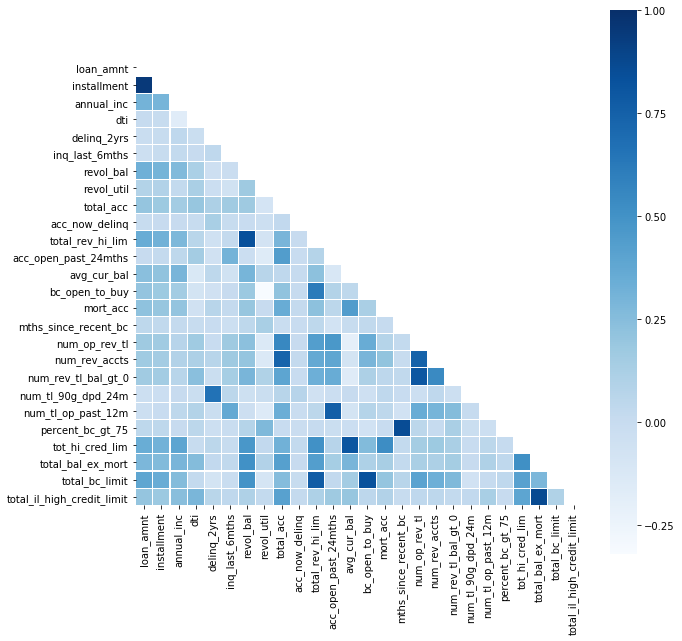

In [226]:
corr=x_trn_num[lg_feas].corr()
plt.figure(figsize=(10,10))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,cmap=plt.cm.Blues,mask=mask,square=True,annot_kws={'size':8},linewidths=0.1)

In [227]:
lg_feas.remove('installment')
lg_feas.remove('revol_bal')
lg_feas.remove('total_acc')
lg_feas.remove('num_rev_tl_bal_gt_0')
lg_feas.remove('num_op_rev_tl')
lg_feas.remove('total_bal_ex_mort')
lg_feas.remove('total_bc_limit')
lg_feas.remove('tot_hi_cred_lim')
lg_feas.remove('num_tl_op_past_12m')
lg_feas.remove('percent_bc_gt_75')
lg_feas.remove('num_tl_90g_dpd_24m')
lg_feas.remove('total_rev_hi_lim')

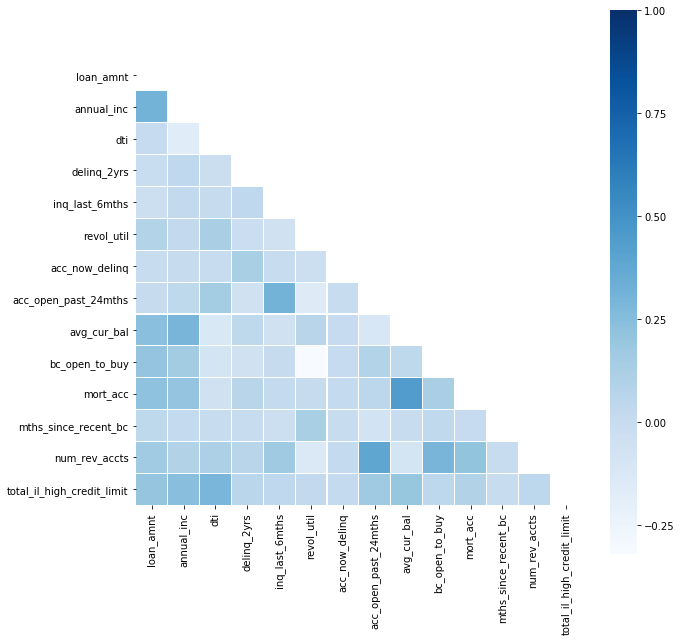

In [228]:
corr=x_trn_num[lg_feas].corr()
plt.figure(figsize=(10,10))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,cmap=plt.cm.Blues,mask=mask,square=True,annot_kws={'size':8},linewidths=0.1)

In [67]:
#use catboost to choose important categorical variables
cb=catboost.CatBoostClassifier(iterations=50,eval_metric='Recall',random_seed=33)
cb.fit(x_trn_cat,y_trn,list(range(x_trn_cat.shape[1])))

0:	learn: 0.0534440	total: 518ms	remaining: 25.4s
1:	learn: 0.0532776	total: 756ms	remaining: 18.1s
2:	learn: 0.0947795	total: 1.15s	remaining: 18s
3:	learn: 0.0947795	total: 1.39s	remaining: 16s
4:	learn: 0.0947795	total: 1.72s	remaining: 15.5s
5:	learn: 0.0947795	total: 1.98s	remaining: 14.5s
6:	learn: 0.0947795	total: 2.29s	remaining: 14.1s
7:	learn: 0.0947795	total: 2.55s	remaining: 13.4s
8:	learn: 0.0948164	total: 2.83s	remaining: 12.9s
9:	learn: 0.0948164	total: 3.12s	remaining: 12.5s
10:	learn: 0.0948164	total: 3.38s	remaining: 12s
11:	learn: 0.0948164	total: 3.68s	remaining: 11.7s
12:	learn: 0.0948164	total: 3.96s	remaining: 11.3s
13:	learn: 0.0948164	total: 4.22s	remaining: 10.8s
14:	learn: 0.0948164	total: 4.48s	remaining: 10.5s
15:	learn: 0.0948164	total: 4.76s	remaining: 10.1s
16:	learn: 0.0948164	total: 5.02s	remaining: 9.75s
17:	learn: 0.0948164	total: 5.33s	remaining: 9.47s
18:	learn: 0.0948164	total: 5.64s	remaining: 9.21s
19:	learn: 0.0948164	total: 6.03s	remaining: 9.

In [68]:
fea_imp=pd.DataFrame(cb.feature_importances_,index=x_trn_cat.columns,columns=['importance'])
fea_imp[fea_imp.importance>0].sort_values('importance',ascending=False)

,importance
term,57.515931
home_ownership,20.662757
verification_status,16.720405
initial_list_status,3.129605
addr_state,1.351113
purpose,0.527145
application_type,0.093043


In [28]:
cb_feas=fea_imp[fea_imp.importance>5].index.tolist()

In [229]:
feas=lg_feas+cb_feas

In [230]:
len(feas)

17

In [231]:
feas

['loan_amnt',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'inq_last_6mths',
 'revol_util',
 'acc_now_delinq',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_open_to_buy',
 'mort_acc',
 'mths_since_recent_bc',
 'num_rev_accts',
 'total_il_high_credit_limit',
 'term',
 'home_ownership',
 'verification_status']

In [265]:
x_trn_sel=x_trn[lg_feas]
x_tes_sel=x_tes[lg_feas]

In [266]:
x_trn_dum=pd.get_dummies(x_trn_sel)
x_tes_dum=pd.get_dummies(x_tes_sel)

In [267]:
scaler = MinMaxScaler()
scaler.fit(x_trn_dum)
x_trn_scal = scaler.transform(x_trn_dum)
x_tes_scal = scaler.transform(x_tes_dum)

In [271]:
clt_lg = LogisticRegression(class_weight={0:0.26,1:0.74})
clt_lg.fit(np.array(x_trn_scal),np.array(y_trn))
print(metrics.classification_report(np.array(y_tes),clt_lg.predict(np.array(x_tes_scal))))
recall_trn = metrics.recall_score(np.array(y_trn),clt_lg.predict(np.array(x_trn_scal)))
print("Training Recall:",recall_trn)
recall_tes = metrics.recall_score(np.array(y_tes),clt_lg.predict(np.array(x_tes_scal)))
print("Test Recall:",recall_tes)
fpr, tpr, thresholds = metrics.roc_curve(np.array(y_tes),clt_lg.predict(np.array(x_tes_scal)))
print("Test AUC:",metrics.auc(fpr, tpr))

             precision    recall  f1-score   support

          0       0.83      0.57      0.68     37569
          1       0.36      0.67      0.47     13455

avg / total       0.70      0.60      0.62     51024

Training Recall: 0.6646578178725921
Test Recall: 0.6673355629877369
Test AUC: 0.6199277298555497


In [272]:
x_trn_scal.shape

(204094, 14)

In [250]:
x_trn_sel[feas].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204094 entries, 205994 to 154644
Data columns (total 17 columns):
loan_amnt                     204094 non-null int32
annual_inc                    204094 non-null float64
dti                           204094 non-null float64
delinq_2yrs                   204094 non-null int32
inq_last_6mths                204094 non-null int32
revol_util                    204094 non-null float64
acc_now_delinq                204094 non-null int32
acc_open_past_24mths          204094 non-null int32
avg_cur_bal                   204094 non-null int32
bc_open_to_buy                204094 non-null int32
mort_acc                      204094 non-null int32
mths_since_recent_bc          204094 non-null int32
num_rev_accts                 204094 non-null int32
total_il_high_credit_limit    204094 non-null int32
term                          204094 non-null object
home_ownership                204094 non-null object
verification_status           204094 non-nul

In [268]:
X=pd.DataFrame(x_trn_scal,columns=x_trn_dum.columns,index=x_trn_num.index)

In [269]:
import statsmodels.api as sm
from scipy import stats
x1=sm.add_constant(X)
est=sm.OLS(y_trn,x1)
est2=est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                  label   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     965.7
Date:                Sat, 31 Mar 2018   Prob (F-statistic):               0.00
Time:                        18:28:27   Log-Likelihood:            -1.1612e+05
No. Observations:              204094   AIC:                         2.323e+05
Df Residuals:                  204079   BIC:                         2.324e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [273]:
clt_rfc = RandomForestClassifier(max_depth=20)
clt_rfc.fit(np.array(x_trn_scal),np.array(y_trn))
print(metrics.classification_report(np.array(y_tes),clt_rfc.predict(np.array(x_tes_scal))))
recall_trn = metrics.recall_score(np.array(y_trn),clt_rfc.predict(np.array(x_trn_scal)))
print("Training Recall:",recall_trn)
recall_tes = metrics.recall_score(np.array(y_tes),clt_rfc.predict(np.array(x_tes_scal)))
print("Test Recall:",recall_tes)

             precision    recall  f1-score   support

          0       0.75      0.93      0.83     37569
          1       0.44      0.16      0.23     13455

avg / total       0.67      0.73      0.67     51024

Training Recall: 0.699356675416867
Test Recall: 0.15510962467484207


In [238]:
# oversampling
sm = SMOTE(random_state=12)
x_trn_sm, y_trn_sm = sm.fit_sample(x_trn_scal, y_trn)

In [239]:
print(np.unique(y_trn, return_counts = True))
print(np.unique(y_trn_sm, return_counts = True))

(array([0, 1]), array([150000,  54094], dtype=int64))
(array([0, 1]), array([150000, 150000], dtype=int64))


In [240]:
clt_lg = LogisticRegression()
clt_lg.fit(np.array(x_trn_sm),np.array(y_trn_sm))
print('logistic regression: ')
print('Test confusion matrix:')
print(metrics.classification_report(np.array(y_tes),clt_lg.predict(np.array(x_tes_scal))))
recall_trn = metrics.recall_score(np.array(y_trn_sm),clt_lg.predict(np.array(x_trn_sm)))
print("Training Recall:",recall_trn)
fpr, tpr, thresholds = metrics.roc_curve(np.array(y_trn_sm),clt_lg.predict(np.array(x_trn_sm)))
print("Training AUC:",metrics.auc(fpr, tpr))
recall_tes = metrics.recall_score(np.array(y_tes),clt_lg.predict(np.array(x_tes_scal)))
print("Test Recall:",recall_tes)
fpr, tpr, thresholds = metrics.roc_curve(np.array(y_tes),clt_lg.predict(np.array(x_tes_scal)))
print("Test AUC:",metrics.auc(fpr, tpr))

print('/n')
clt_rfc.fit(np.array(x_trn_sm),np.array(y_trn_sm))
print('Random Forest: ')
print('Test confusion matrix:')
print(metrics.classification_report(np.array(y_tes),clt_rfc.predict(np.array(x_tes_scal))))
recall_trn = metrics.recall_score(np.array(y_trn_sm),clt_rfc.predict(np.array(x_trn_sm)))
print("Training Recall:",recall_trn)
fpr, tpr, thresholds = metrics.roc_curve(np.array(y_trn_sm),clt_rfc.predict(np.array(x_trn_sm)))
print("Training AUC:",metrics.auc(fpr, tpr))
recall_tes = metrics.recall_score(np.array(y_tes),clt_rfc.predict(np.array(x_tes_scal)))
print("Test Recall:",recall_tes)
fpr, tpr, thresholds = metrics.roc_curve(np.array(y_tes),clt_rfc.predict(np.array(x_tes_scal)))
print("Test AUC:",metrics.auc(fpr, tpr))

logistic regression: 
Test confusion matrix:
             precision    recall  f1-score   support

          0       0.83      0.65      0.73     37569
          1       0.39      0.63      0.49     13455

avg / total       0.72      0.65      0.67     51024

Training Recall: 0.6462466666666666
Training AUC: 0.6479199999999999
Test Recall: 0.6330732069862505
Test AUC: 0.6422572774530391
/n
Random Forest: 
Test confusion matrix:
             precision    recall  f1-score   support

          0       0.80      0.75      0.77     37569
          1       0.40      0.46      0.43     13455

avg / total       0.69      0.68      0.68     51024

Training Recall: 0.9401266666666667
Training AUC: 0.91753
Test Recall: 0.461092530657748
Test AUC: 0.6077189342846621


In [130]:
xgb = tree.DecisionTreeClassifier(max_depth=30)
xgb.fit(x_trn_scal,y_trn)
print('Test confusion matrix:')
print(metrics.classification_report(np.array(y_tes),xgb.predict(np.array(x_tes_scal))))
recall_trn = metrics.recall_score(np.array(y_trn),xgb.predict(np.array(x_trn_scal)))
print("Training Recall:",recall_trn)
fpr, tpr, thresholds = metrics.roc_curve(np.array(y_trn),xgb.predict(np.array(x_trn_scal)))
print("Training AUC:",metrics.auc(fpr, tpr))
recall_tes = metrics.recall_score(np.array(y_tes),xgb.predict(np.array(x_tes_scal)))
print("Test Recall:",recall_tes)
fpr, tpr, thresholds = metrics.roc_curve(np.array(y_tes),xgb.predict(np.array(x_tes_scal)))
print("Test AUC:",metrics.auc(fpr, tpr))

Test confusion matrix:
             precision    recall  f1-score   support

          0       0.76      0.75      0.76     37569
          1       0.34      0.36      0.35     13455

avg / total       0.65      0.65      0.65     51024

Training Recall: 0.9829740821532887
Training AUC: 0.9910537077433109
Test Recall: 0.35570419918246005
Test AUC: 0.5530816771684879


In [131]:
xgb.fit(x_trn_sm,y_trn_sm)
print('Test confusion matrix:')
print(metrics.classification_report(np.array(y_tes),xgb.predict(np.array(x_tes_scal))))
recall_trn = metrics.recall_score(np.array(y_trn_sm),xgb.predict(np.array(x_trn_sm)))
print("Training Recall:",recall_trn)
fpr, tpr, thresholds = metrics.roc_curve(np.array(y_trn_sm),xgb.predict(np.array(x_trn_sm)))
print("Training AUC:",metrics.auc(fpr, tpr))
recall_tes = metrics.recall_score(np.array(y_tes),xgb.predict(np.array(x_tes_scal)))
print("Test Recall:",recall_tes)
fpr, tpr, thresholds = metrics.roc_curve(np.array(y_tes),xgb.predict(np.array(x_tes_scal)))
print("Test AUC:",metrics.auc(fpr, tpr))

Test confusion matrix:
             precision    recall  f1-score   support

          0       0.77      0.73      0.75     37569
          1       0.34      0.39      0.37     13455

avg / total       0.66      0.64      0.65     51024

Training Recall: 0.98856
Training AUC: 0.98812
Test Recall: 0.39316239316239315
Test AUC: 0.5614831103931159


### VIF
.....

In [61]:
# according to vif, exclude: 
dff.drop(['num_sats','tot_cur_bal','installment','total_acc','num_rev_tl_bal_gt_0',
          'revol_bal','num_op_rev_tl','num_rev_accts','bc_open_to_buy'],axis=1,inplace=True)
dff.shape

In [70]:
l_int=dff.select_dtypes(include=['int']).columns.tolist()

C:\Users\Yingting-PC\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


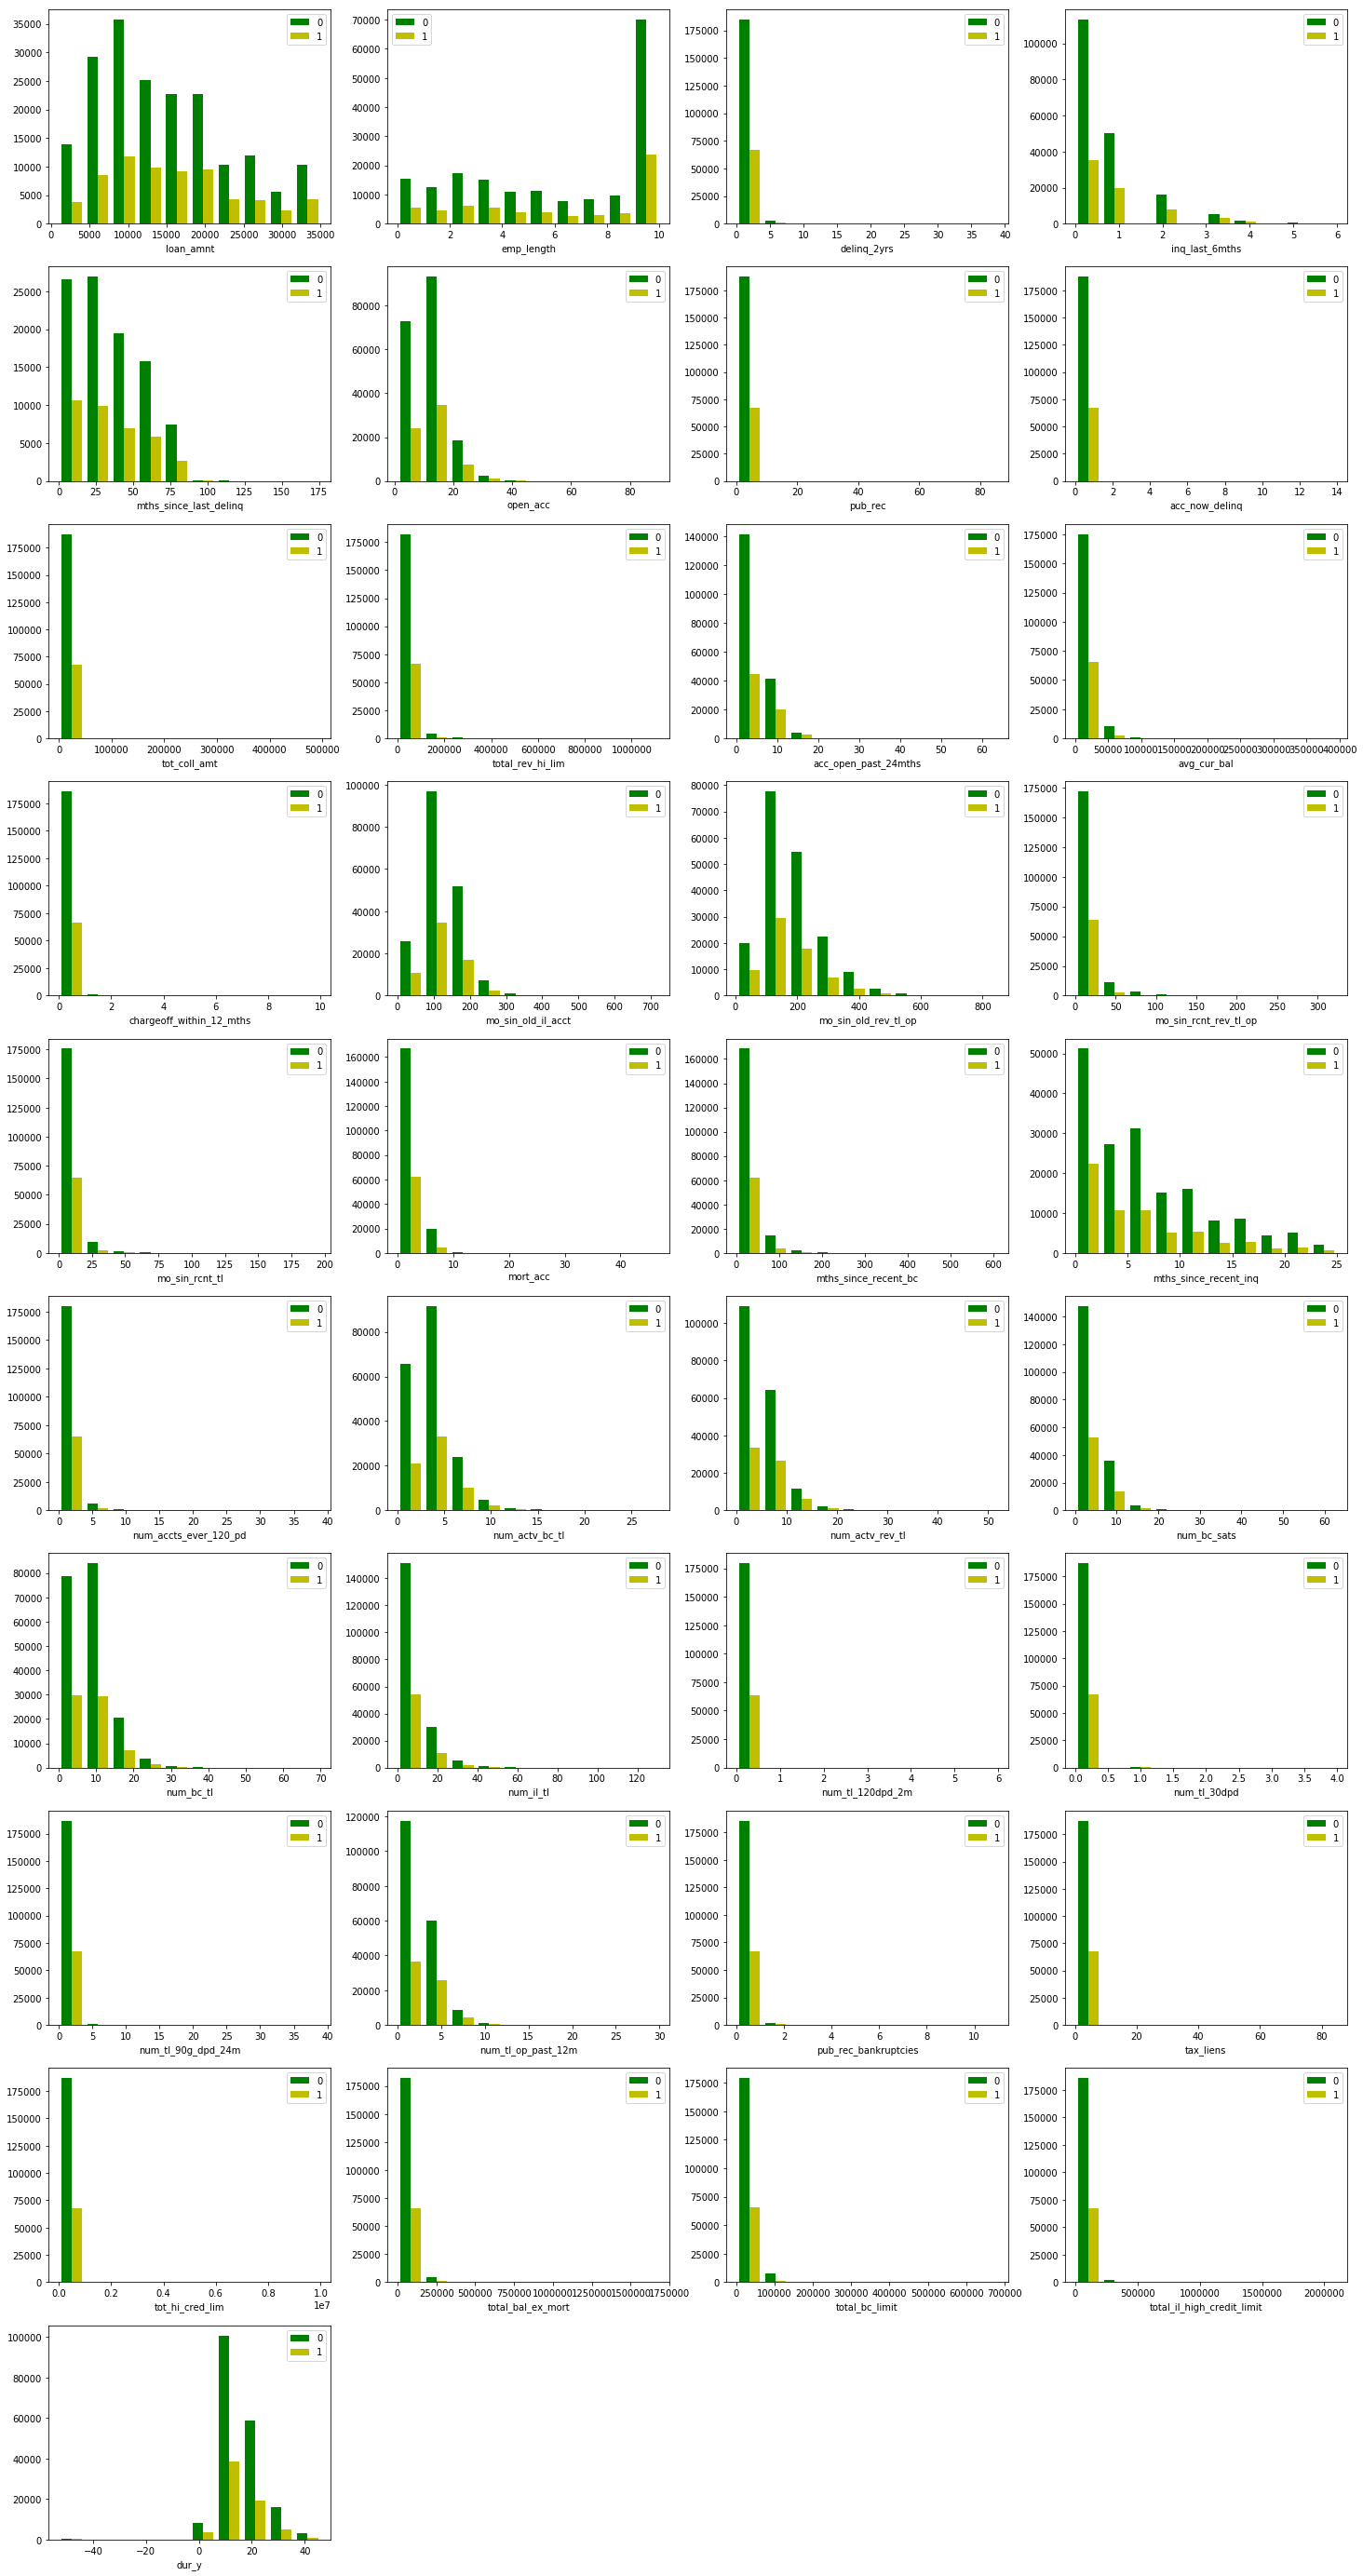

In [71]:
fig = plt.figure(figsize=(25,50))
for i in range(len(l_int)):
    ax=fig.add_subplot(10, 4, i+1)
    x1=dff[dff['label']=='0'][l_int[i]]
    x2=dff[dff['label']=='1'][l_int[i]]
    x1=x1[x1!=-999]
    x2=x2[x2!=-999]
    ax.hist([x1, x2], color=['g','y'], label=['0','1'])
    ax.set_xlabel(l_int[i])
    ax.legend()

In [19]:
l_float=dff.select_dtypes(include=['float']).columns.tolist()

C:\Users\Yingting-PC\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


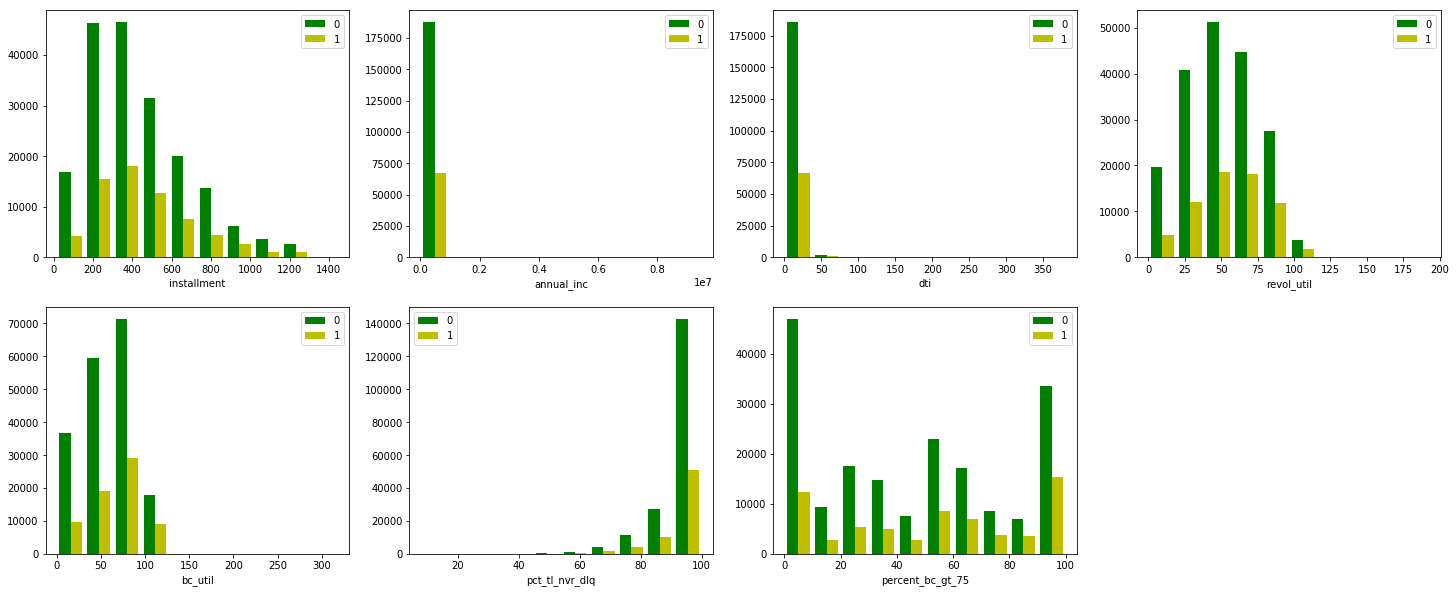

In [20]:
fig = plt.figure(figsize=(25,10))
for i in range(len(l_float)):
    ax=fig.add_subplot(2, 4, i+1)
    x1=dff[dff['label']=='0'][l_float[i]]
    x2=dff[dff['label']=='1'][l_float[i]]
    x1=x1[x1!=-999]
    x2=x2[x2!=-999]
    ax.hist([x1, x2], color=['g','y'], label=['0','1'])
    ax.set_xlabel(l_float[i])
    ax.legend()

#### bining 'annual_inc','dti','bc_until','pct_tl_nvr_dlq'?

In [145]:
def num2cat(new_col,old_col,data):
    data[new_col]=0
    data.loc[data[old_col]<=np.percentile(data[old_col],25),new_col]='low'
    data.loc[(data[old_col]>np.percentile(data[old_col],25))&(data[old_col]<=np.percentile(data[old_col],50)),new_col]='med_low'
    data.loc[(data[old_col]>np.percentile(data[old_col],50))&(data[old_col]<=np.percentile(data[old_col],75)),new_col]='med_hig'
    data.loc[(data[old_col]>np.percentile(data[old_col],75)),new_col]='hig'
    data.loc[data[old_col]==-999,new_col]='-999'

In [146]:
for i in dff.select_dtypes(include=['float','int']).columns:
    num2cat(i+'_level',i,dff)

In [148]:
dff.drop(dff.select_dtypes(include=['float','int']).columns.tolist(),axis=1,inplace=True)

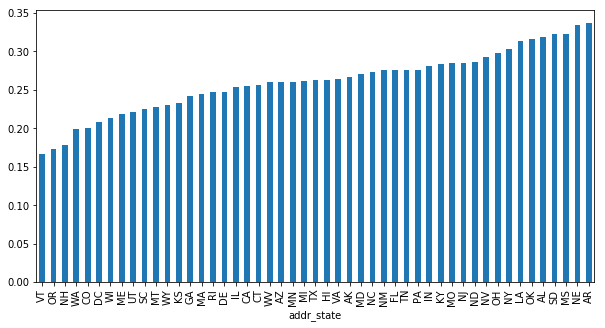

In [94]:
plt.figure(figsize=(10,5)) 
state_ct=pd.crosstab(dff.addr_state,dff.label).sort_values('1')
state_ct['default%'] = state_ct['1']/(state_ct['0'] + state_ct['1'])
state_ct['default%'].sort_values().plot(kind='bar')

In [74]:
l_object=dff.select_dtypes(include=['object']).columns.tolist()

In [96]:
state_ct.sort_values('default%',ascending=False,inplace=True)
level_4 = state_ct[state_ct['default%']>=0.3].index.tolist()
level_3 = state_ct[(state_ct['default%']>=0.26)&(state_ct['default%']<0.3)].index.tolist()
level_2 = state_ct[(state_ct['default%']>=0.2)&(state_ct['default%']<0.26)].index.tolist()
level_1 = state_ct[state_ct['default%']<0.2].index.tolist()

dff.loc[dff.addr_state.isin(level_4),'addr_state'] = 'st_level_4'
dff.loc[dff.addr_state.isin(level_3),'addr_state'] = 'st_level_3'
dff.loc[dff.addr_state.isin(level_2),'addr_state'] = 'st_level_2'
dff.loc[dff.addr_state.isin(level_1),'addr_state'] = 'st_level_1'

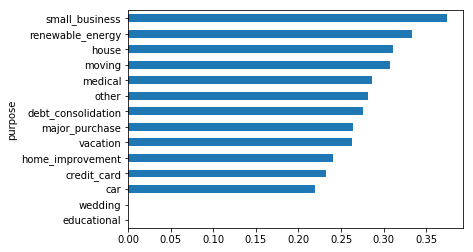

In [97]:
purpose_ct = pd.crosstab(dff.purpose,dff.label).sort_values('1',ascending=False)
purpose_ct['default%'] = purpose_ct['1']/(purpose_ct['0'] + purpose_ct['1'])
purpose_ct['loan_amnt_med'] = dff.groupby('purpose')['loan_amnt'].median()
purpose_ct['default%'].sort_values().plot(kind='barh')

In [98]:
purp_subset=['medical','moving','car','vacation','house','renewable_energy','educational','wedding']
dff.loc[dff.purpose.isin(purp_subset),'purpose'] = 'other'

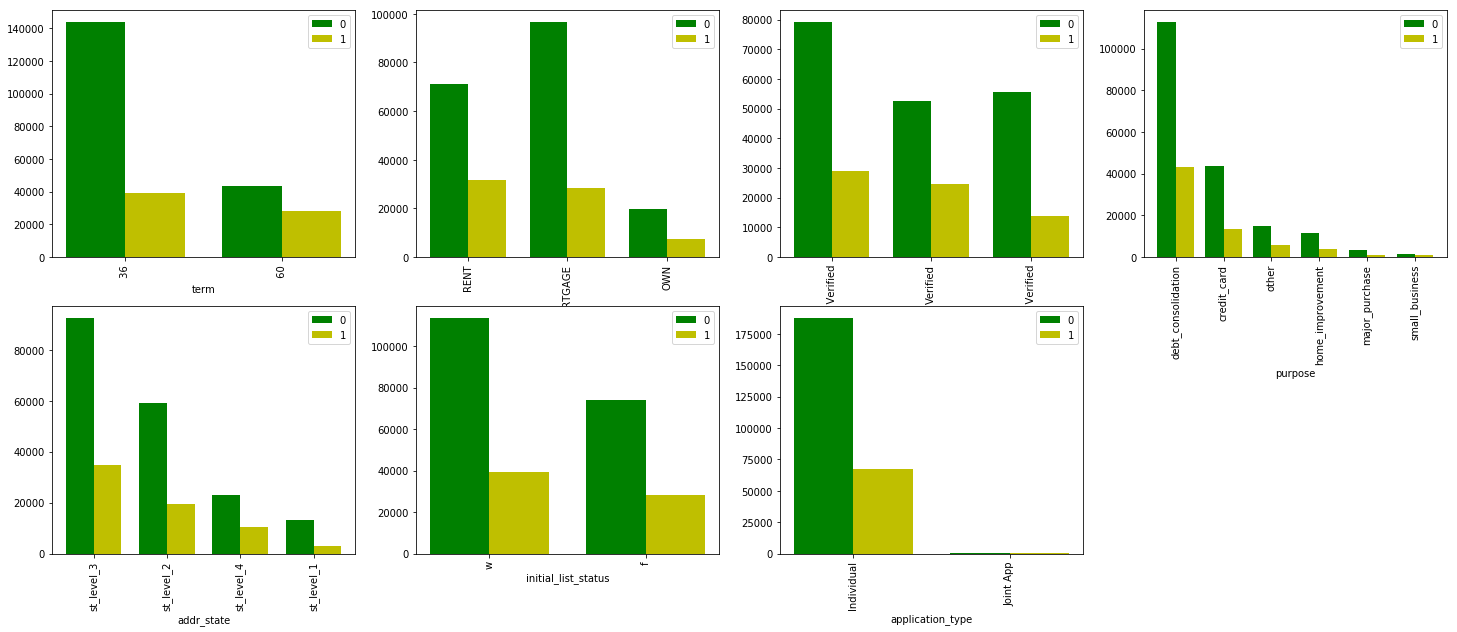

In [99]:
fig = plt.figure(figsize=(25,10))
for i in range(len(l_object[:-1])):
    ax=fig.add_subplot(2, 4, i+1,)
    fea_df=dff[l_object[i]]
    fea_ct=pd.crosstab(fea_df[fea_df!='-999'],dff.label).sort_values('1',ascending=False)
    width=0.38
    ind=np.arange(len(fea_ct.index))
    ax.bar(ind,fea_ct.iloc[:,0],width,color=['g'], label='0')
    ax.bar(ind+width,fea_ct.iloc[:,1],width,color=['y'], label='1')
    ax.set_xlabel(l_object[i])
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(fea_ct.index.tolist())
    ax.legend()
    plt.setp(ax.get_xticklabels(), fontsize=10, rotation='vertical')

In [101]:
import scipy.stats as sps
for i in l_object[:-1]:
    cont_tb = pd.crosstab(index=dff[i],columns=dff['label'])
    print(i,sps.chi2_contingency(cont_tb, correction=False)[:3])

term (8751.415316738741, 0.0, 1)
home_ownership (2026.8416013515534, 0.0, 2)
verification_status (2660.137314618011, 0.0, 2)
purpose (594.6595192347806, 2.8822827855387865e-126, 5)
addr_state (958.3730017718984, 1.9279983616815544e-207, 3)
initial_list_status (103.42186051503026, 2.7086939948729914e-24, 1)
application_type (4.5801301714989835, 0.03234475764416881, 1)


In [151]:
# https://tech.yandex.com/catboost/doc/dg/concepts/parameter-tuning-docpage/
cb=catboost.CatBoostClassifier(iterations=50,eval_metric='Accuracy',random_seed=33)

In [168]:
X_col=dff.columns.tolist()
X_col.remove('label')

In [169]:
cb.fit(dff.loc[:,X_col],dff['label'],list(range(len(dff.columns)-1)))

0:	learn: 0.7400615	total: 3.81s	remaining: 3m 6s
1:	learn: 0.7402692	total: 7.55s	remaining: 3m 1s
2:	learn: 0.7403515	total: 10.9s	remaining: 2m 51s
3:	learn: 0.7408297	total: 13.8s	remaining: 2m 38s
4:	learn: 0.7403554	total: 17.5s	remaining: 2m 37s
5:	learn: 0.7405044	total: 20.8s	remaining: 2m 32s
6:	learn: 0.7405044	total: 23.8s	remaining: 2m 25s
7:	learn: 0.7413471	total: 26.2s	remaining: 2m 17s
8:	learn: 0.7419312	total: 29.2s	remaining: 2m 13s
9:	learn: 0.7421115	total: 32.3s	remaining: 2m 9s
10:	learn: 0.7421389	total: 35.3s	remaining: 2m 5s
11:	learn: 0.7422996	total: 38s	remaining: 2m
12:	learn: 0.7426524	total: 40.7s	remaining: 1m 55s
13:	learn: 0.7426171	total: 43.4s	remaining: 1m 51s
14:	learn: 0.7425740	total: 46.5s	remaining: 1m 48s
15:	learn: 0.7427739	total: 49.5s	remaining: 1m 45s
16:	learn: 0.7428131	total: 52.1s	remaining: 1m 41s
17:	learn: 0.7427583	total: 55.1s	remaining: 1m 37s
18:	learn: 0.7429111	total: 58s	remaining: 1m 34s
19:	learn: 0.7430326	total: 1m	rem

In [170]:
fea_imp=pd.DataFrame(cb.feature_importances_,index=X_col,columns=['importance'])
fea_imp[fea_imp.importance>0].sort_values('importance',ascending=False)

,importance
term,38.979370
dti_level,8.784715
tot_hi_cred_lim_level,7.951433
acc_open_past_24mths_level,6.939940
total_bc_limit_level,5.910658
bc_open_to_buy_level,4.983659
home_ownership,4.831439
inq_last_6mths_level,3.882373
mort_acc_level,3.646928
percent_bc_gt_75_level,3.324659


In [175]:
imp_col=fea_imp[fea_imp.importance>0].index.tolist()

In [196]:
X_dummy = pd.get_dummies(dff.loc[:,imp_col],drop_first=True)
Y=dff['label'].astype('int')

In [197]:
x_trn, x_tes, y_trn, y_tes = train_test_split(X_dummy,Y,test_size=0.2, random_state=33)

In [198]:
rfc = RandomForestClassifier()
rfc.fit(np.array(x_trn),np.array(y_trn))
accu_trn = metrics.accuracy_score(y_trn,rfc.predict(x_trn))
print("Training Auc:",accu_trn)
accu_tes = metrics.accuracy_score(np.array(y_tes),rfc.predict(np.array(x_tes)))
print("Test Auc:",accu_tes)

Training Auc: 0.9777896459474555
Test Auc: 0.7278731577296959


In [199]:
recall_trn = metrics.recall_score(np.array(y_trn),rfc.predict(x_trn))
print("Training recall:",recall_trn)
recall_tes = metrics.recall_score(np.array(y_tes),rfc.predict(np.array(x_tes)))
print("Test recall:",recall_tes)

Training recall: 0.9184567604540245
Test recall: 0.1540691192865106


In [203]:
print(metrics.classification_report(np.array(y_tes),rfc.predict(np.array(x_tes))))

             precision    recall  f1-score   support

          0       0.75      0.93      0.83     37569
          1       0.45      0.15      0.23     13455

avg / total       0.68      0.73      0.68     51024



In [204]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=12,ratio=0.5)
x_trn_sm, y_trn_sm = sm.fit_sample(x_trn, y_trn)
rfc.fit(np.array(x_trn_sm),np.array(y_trn_sm))
print(metrics.classification_report(np.array(y_tes),rfc.predict(np.array(x_tes))))

C:\Users\Yingting-PC\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


             precision    recall  f1-score   support

          0       0.76      0.93      0.84     37569
          1       0.47      0.17      0.25     13455

avg / total       0.68      0.73      0.68     51024

